In [1]:
#gstat package example

rm(list = ls())
graphics.off()
library(lhs)
library(gstat)
library(sp)
options(warn=-1)
#Problem definition
#Output is 1 if the product of two numbers is larger than 0.75, x1, x2 are both uniformly distributed in [0,1]
Reliability<-function (X) {
  X[ ,1]*X[ ,2]
}


In [2]:
# 100 * 100 = 10000 total points, select 20 as initial samples, fit a Kriging model response to the rest points.
level <- seq(0, 1, length=100)
N <- 10000
X_ALL <- expand.grid(level,level)
Grid <- data.frame(X1=X_ALL$Var1,X2=X_ALL$Var2)
n <- 20
n_init <- n
# take 20 random points from the 10000 points
indx <- sample(N,n)
# x are the used samples
x <- Grid[indx, ]
# X are the rest points to be estimated
X <- Grid[-indx, ]
y <- Reliability(x)
Data <- data.frame(X1=x$X1,X2=x$X2,y=y)
coordinates(Data)=~X1+X2
# Fit a variogram
TheVariogram=variogram(y~1, data=Data)
FittedModel <- fit.variogram(TheVariogram, vgm("Exp"))
TheGStat <- gstat(id="Rel", formula=y ~ 1, data=Data,model=FittedModel )
XX <- X
coordinates(XX) <- ~ X1+X2
# Fit the Kriging surface to the rest points
KrigSurface <- predict(TheGStat, model=FittedModel, newdata=XX)

[using ordinary kriging]


In [3]:
mean <- KrigSurface$Rel.pred
std <- sqrt(KrigSurface$Rel.var)
# P_fail is the estimated failing probability (here the threshold is 0.75)
P_fail <- (sum(mean>0.75)+sum(y>0.75))/N
# U is the learning function for the adaptive learning part, each time choose the point with minimum U
# A new sample should be either very close to 0.5 or have a large standard error
U <- abs(mean-0.75)/std
print(c(min(U),P_fail))
if (is.na(P_fail))
  P_fail <- 0
if (is.na(U))
  U <- 0

[1] 0.001337938 0.022800000


In [4]:
# Adaptive sampling
# Stopping threshold is defined as 0.5
while ((min(U)<=0.5) | P_fail==0){
  n <- n+1
  i <- which(U==min(U))
    # Randomly choose a new sample if multiple samples have the same minimum U
  if (length(i)>1){
    i <- sample(i,1)
  }
    # Update new x, y, X
  y <- append(y,Reliability(X[i, ]))
  x <- rbind.data.frame(x,X[i, ])
  X <- X[-i, ]
  XX <- X
  coordinates(XX) <- ~ X1+X2
  Data <- data.frame(X1=x$X1,X2=x$X2,y=y)
  coordinates(Data)=~X1+X2
    # Fit a new variogram and Kriging model
  TheVariogram=variogram(y~1, data=Data)
  FittedModel <- fit.variogram(TheVariogram, vgm("Exp"))
  TheGStat <- gstat(id="Rel", formula=y ~ 1, data=Data,model=FittedModel )
  KrigSurface <- predict(TheGStat, model=FittedModel, newdata=XX)
  mean <- KrigSurface$Rel.pred
  std <- sqrt(KrigSurface$Rel.var)
    # Update new failing probability and learning function
  P_fail <- (sum(mean>0.75)+sum(y>0.75))/N
  if (is.na(P_fail))
    P_fail <- 0
  U <- abs(mean-0.75)/std
  if (is.na(U))
    U <- 0
  print(c(n,min(U),P_fail))
}

[using ordinary kriging]
[1] 2.100000e+01 5.079895e-06 3.040000e-02
[using ordinary kriging]
[1] 22.00000000  0.00184651  0.03590000
[using ordinary kriging]
[1] 23.000000000  0.005044792  0.034300000
[using ordinary kriging]
[1] 2.400000e+01 1.199085e-04 3.650000e-02
[using ordinary kriging]
[1] 2.50000e+01 3.19384e-04 3.67000e-02
[using ordinary kriging]
[1] 26.000000000  0.003704565  0.036700000
[using ordinary kriging]
[1] 2.700000e+01 7.562267e-04 3.620000e-02
[using ordinary kriging]
[1] 28.000000000  0.001621632  0.036400000
[using ordinary kriging]
[1] 29.00000000  0.00312612  0.03670000
[using ordinary kriging]
[1] 30.000000000  0.001225807  0.036800000
[using ordinary kriging]
[1] 31.000000000  0.003816062  0.036700000
[using ordinary kriging]
[1] 32.000000000  0.006318773  0.036600000
[using ordinary kriging]
[1] 33.000000000  0.008991552  0.036600000
[using ordinary kriging]
[1] 34.000000000  0.003464192  0.036400000
[using ordinary kriging]
[1] 35.000000000  0.006576938  0

[using ordinary kriging]


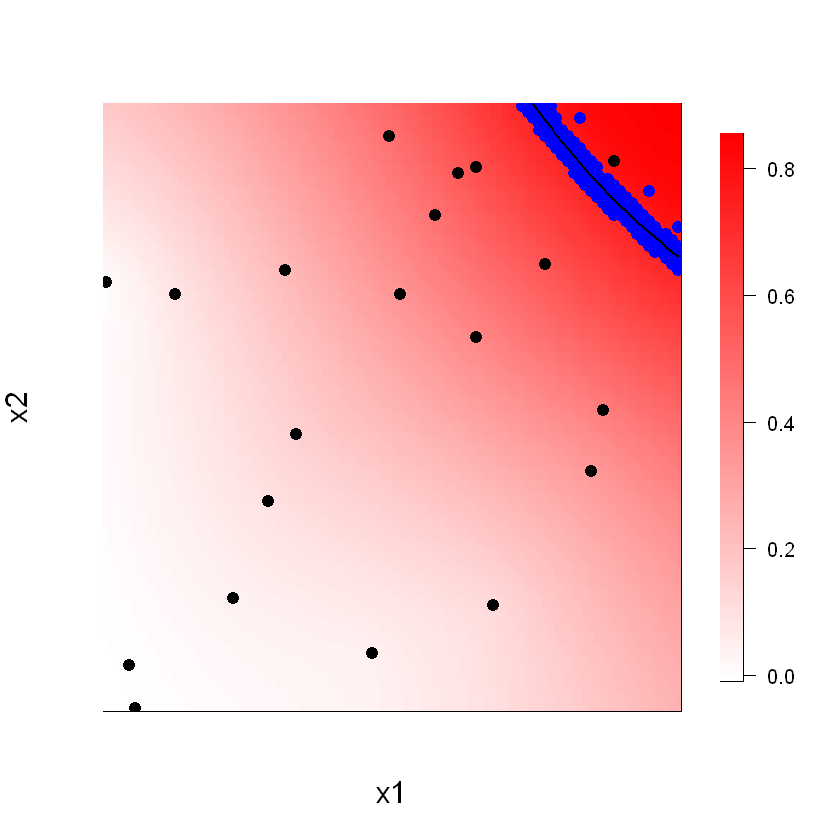

In [8]:
Grid <- data.frame(X1=X_ALL$Var1,X2=X_ALL$Var2)
coordinates(Grid) <- ~ X1+X2
KrigSurface <- predict(TheGStat, model=FittedModel, newdata=Grid)

colfunc <- colorRampPalette(c("white", "red"))
cols <- colfunc(100)
image.plot(level,level, matrix(KrigSurface$Rel.pred,ncol=100),xaxt="n",yaxt="n", xlab="x1", ylab="x2", col=cols,cex.lab=1.5,cex.axis=1.5)
points(x$X1[1:n_init],x$X2[1:n_init],pch=20,cex=2)
points(x$X1[(n_init+1):n],x$X2[(n_init+1):n],pch=20,cex=2,col="blue")
lines(level,0.75/level,lwd=2)